In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_rel, wilcoxon, probplot

from IPython.display import display, HTML

# Import Raw Dataset

In [2]:
# Use your own csv data file.
# If with missing scores, run the Impute notebook and use the new csv

df_Scores = pd.read_csv('Datasets/ArcaneSample.csv', index_col=0)
df_Scores = df_Scores.fillna(0)

df_Scores['Difference'] = df_Scores['Posttest'] - df_Scores['Pretest']  
df_Scores

Sex  Age  Grade  IsSecondTime  Pretest  Posttest  Difference
Surname                                                               
Apresto     F   10      4           0.0      0.0       0.0         0.0
Bargo       F   10      5           0.0      6.0       6.0         0.0
Callos      F   11      6           0.0      4.0       3.0        -1.0
Capillano   F   11      6           0.0      2.0       2.0         0.0
Galan       F   12      6           1.0      0.0       3.0         3.0
Gonzaga     M   11      6           1.0      0.0       2.0         2.0
Helig       F    8      4           0.0      4.0       4.0         0.0
Hermano     F   11      6           1.0      4.0       1.0        -3.0
Loyola      F    9      5           0.0      6.0       6.0         0.0
Malabriga   F   11      4           0.0      0.0       0.0         0.0
Mendoza     M    9      5           0.0      5.0       4.0        -1.0
Nera        M   11      6           1.0      3.0       2.0        -1.0
Parame      M   10      4           0.0      0.0       0.0         0.0
Tolentino   M    9      5           0.0      6.0       5.0        -1.0

# Pipeline

1. Determine Normality of Delta Score between Pretest and Postest
    1. If normal, use `paired t-test` to measure significant difference from mean.
    2. Else, use `wilcoxon` to measure significant difference from median.
2. Evaluate p_value
    1. Significant change if p < threshold (0.05)
3. Evaluate effect
    1. If normal, use `Cohen's D`.
    2. Else, use `Rank-biserial correlation`. 

In [3]:
df_Scores.describe()

Age      Grade  IsSecondTime    Pretest   Posttest  Difference
count  14.000000  14.000000     14.000000  14.000000  14.000000   14.000000
mean   10.214286   5.142857      0.285714   2.857143   2.714286   -0.142857
std     1.121714   0.864438      0.468807   2.476261   2.091322    1.406422
min     8.000000   4.000000      0.000000   0.000000   0.000000   -3.000000
25%     9.250000   4.250000      0.000000   0.000000   1.250000   -1.000000
50%    10.500000   5.000000      0.000000   3.500000   2.500000    0.000000
75%    11.000000   6.000000      0.750000   4.750000   4.000000    0.000000
max    12.000000   6.000000      1.000000   6.000000   6.000000    3.000000

# Inspect Normality Distribution

## A. Graphical Approach

In [4]:
def DoBoxPlot(df, title_prefix : str):
    cols = ['Pretest','Posttest', 'Difference']
    plt.boxplot(df[cols])
    plt.title(f"Box Plot of {title_prefix} Scores")
    plt.xticks(ticks=np.arange(1, len(cols) + 1), labels=cols, rotation=45)
    plt.ylabel("Value")
    plt.grid(True)
    plt.savefig(f'Graphs/{title_prefix} Box Plot of Scores.png')
    
    plt.show()

### Distribution Curve
Check for symmetry and center.

In [5]:
def DoHistPlot(df, title_prefix : str):
    plt.hist(df['Difference'], bins=20)
    plt.title(f'{title_prefix} Score Difference Distribution')
    plt.xlabel('Score Difference')
    plt.ylabel('Frequency')
    plt.savefig(f'Graphs/{title_prefix} Hist Score Distribution.png')
    plt.show()

### Q-Q Plot
Check if values land precisely on the line.

In [6]:
def DoQQPlot(df, title_prefix : str):
    probplot(df.Difference, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {title_prefix} Score Difference")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.savefig('Graphs/QQ Plot of {title_prefix} Score Difference.png')
    plt.show()

## B. Statistical Approach
### Shapiro for n <= 20

Null Hypothesis is that it's Normal

In [7]:
def EvaluateDataset(df):
    res = {}

    res['Avg Difference'] = df.Difference.mean()
    res['Variance'] = df.Difference.std()
    
    shapiro_result = shapiro(df.Difference)
    
    display(HTML("<b>Computing Normality.</b><br><i>Is distribution Parametric?</i><br><br>"))
    display(HTML(f"<b>Shapiro Wilk Test p : {shapiro_result.pvalue:.4f}</b>"))

    res['Sample size'] = df.shape[0]
    res['Shapiro p'] = shapiro_result.pvalue
    res['IsParametric'] = shapiro_result.pvalue < 0.05 and df.shape[0] >= 10


    if res['IsParametric']:
        display(HTML("<br><b>Using 2 Tailed for Significance & Cohen D for effect</b><br>"))
        
        result = ttest_rel(df.Pretest, df.Posttest)
        display(HTML(f"<b>2 Tailed T test p: {result.pvalue:4f}</b><br>"))
        
        cohens_d = df.Difference.mean() / df.Difference.std()
        display(HTML(f"<b>Cohen's D: {cohens_d:4f}</b><br>"))
        
        res['Significance'] = result.pvalue
        res['Effect'] = cohens_d 


    else:
        display(HTML("<br><b>Using Wilcoxon for Significance & Biserial for effect</b><br><br>"))
        
        result = wilcoxon(df.Difference)
        display(HTML(f"<b>Wilcoxon p: {result.pvalue:4f}</b><br>"))
    
        W = result.statistic
        n = df.shape[0]
        rb_corr = 1 - (2 * W) / (n * (n + 1) / 2)
        
        # rb_corr = result.zstatistic / np.sqrt(df.Difference.size)
        display(HTML(f"<b>Rank-biserial correlation: {rb_corr:.4f}</b><br>"))

        res['Significance'] = result.pvalue
        res['Effect'] = rb_corr 
        
    return res

In [8]:
def DoPretestPosttestComparissonBar(df : pd.DataFrame, col : str):
    df_Agg = df.groupby(col).mean()
    ax = df_Agg.plot(kind="bar")
    plt.title(f'Pretest and Posttest Scores by {col}')
    plt.xticks(rotation=0)
    plt.ylabel('Scores')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', va='center', 
            xytext=(0, 9), 
            textcoords='offset points')
    
    plt.tight_layout()
    plt.show()


def DoScoresnPlot(df : pd.DataFrame, col : str):
    sns.scatterplot(data=df, x='Pretest', y='Posttest', hue=col)
    plt.title(f'Scores Colored by {col}')
    plt.legend(title=col)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()



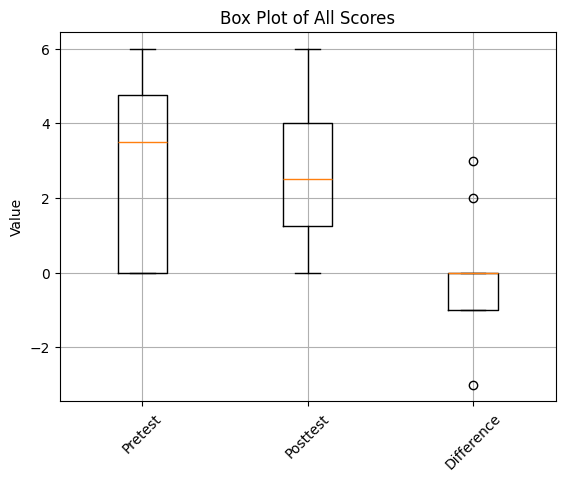

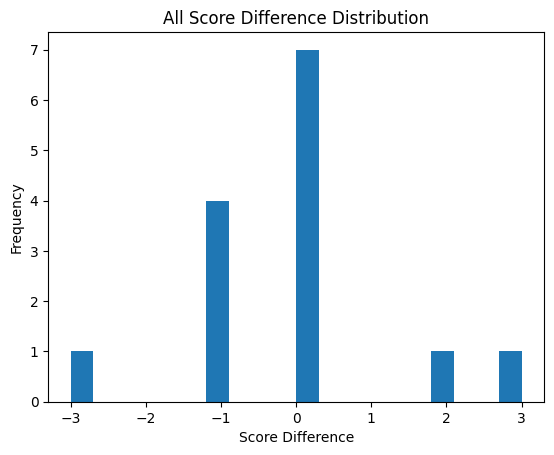

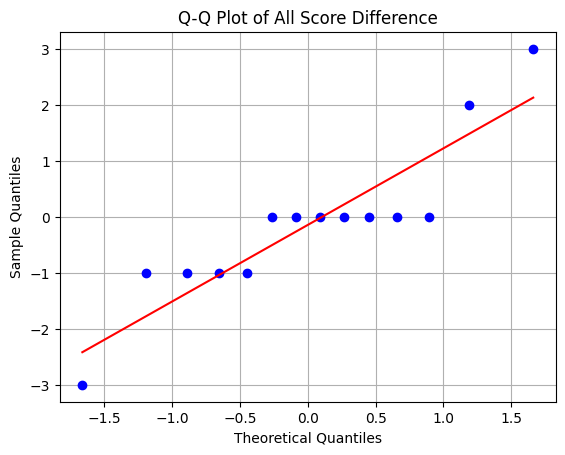

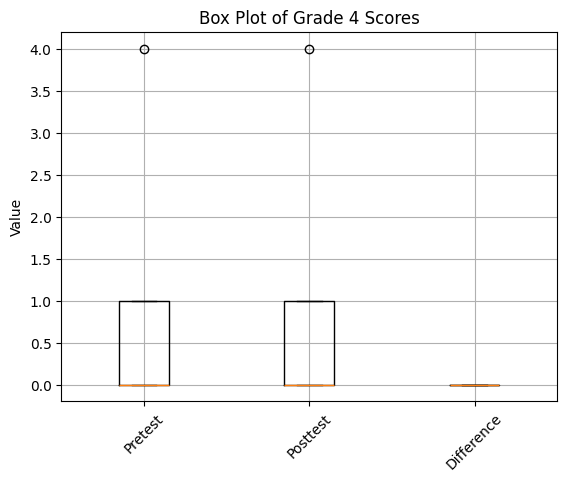

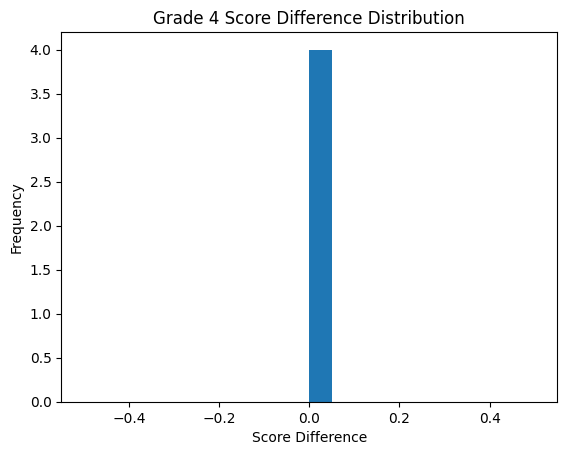

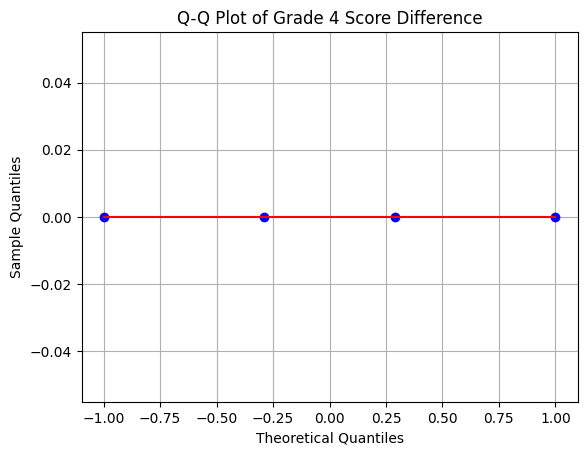

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


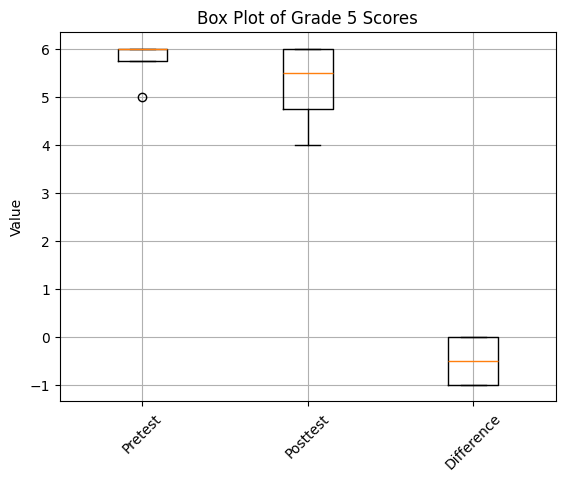

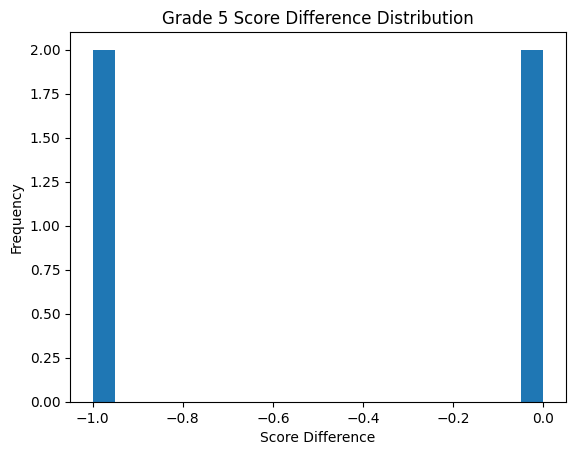

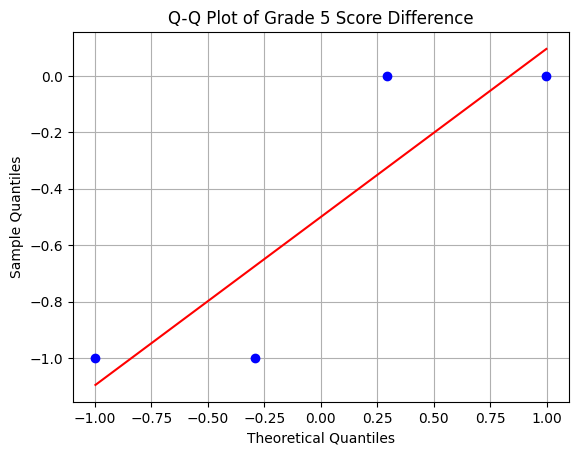

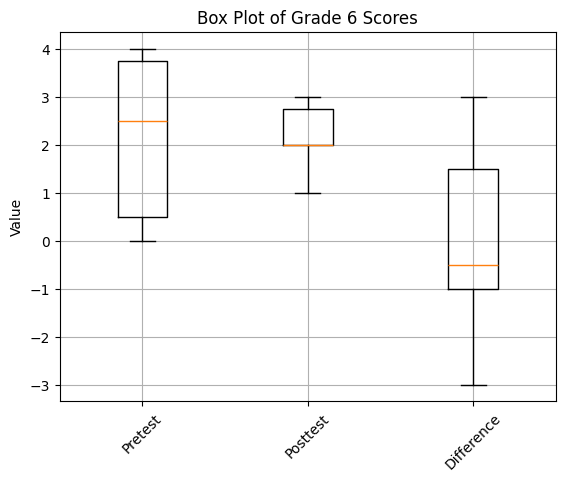

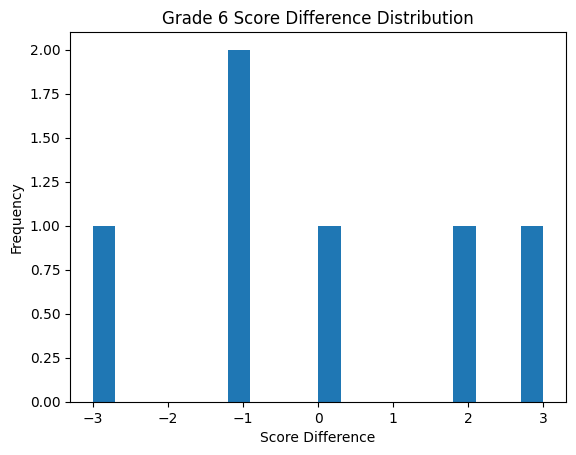

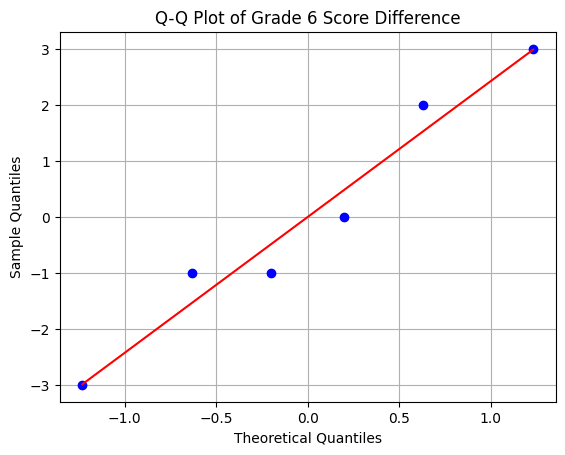

Avg Difference  Variance  Sample size  Shapiro p  IsParametric  \
0       -0.142857  1.406422           14   0.028286          True   
1        0.000000  0.000000            4   1.000000         False   
2       -0.500000  0.577350            4   0.023857         False   
3        0.000000  2.190890            6   0.782827         False   

   Significance    Effect  
0      0.710039 -0.101575  
1      1.000000  1.000000  
2      0.500000  1.000000  
3      1.000000  0.285714

In [9]:
res_List = []


cluster = [
    {
        'name' : "All",
        'df' : df_Scores
    },
    {
        'name' : "Grade 4",
        'df' : df_Scores[df_Scores['Grade'] == 4]
    },
    {
        'name' : "Grade 5",
        'df' : df_Scores[df_Scores['Grade'] == 5]
    },
    {
        'name' : "Grade 6",
        'df' : df_Scores[df_Scores['Grade'] == 6]
    },
]


for item in cluster:
    DoBoxPlot(item['df'], item['name'])
    DoHistPlot(item['df'], item['name'])
    DoQQPlot(item['df'], item['name'])
    res_List.append(EvaluateDataset(item['df']))

pd.DataFrame(res_List)

# Interpret

## Evaluate Significant Difference and Effect

<table>
    <tr>
        <td></td>
        <td><b>T-Test</b></td>
        <td><b>Wilcoxon</b></td>
    </tr>
    <tr>
        <td><b>Sample size</b></td>
        <td></td>
        <td>N <= 20</td>
    </tr>
    <tr>
        <td><b>Normal Distribution</b></td>
        <td>✅</td>
        <td>❌</td>
    </tr>
    <tr>
        <td><b>Signinifigance</b></td>
        <td>Mean</td>
        <td>Median</td>
    </tr>
    <tr>
        <td><b>Effect Metric</b></td>
        <td>Cohen's D</td>
        <td>Rank-biserial Correlation</td>
    </tr>
</table>

<br>

<div align="center">
    <h3>Cohen's D Interpretation</h3>
    <img src='https://www.simplypsychology.org/wp-content/uploads/cohen-d.jpg' alt="Ranges"/>
    <p>Negative magnitude indicates lower Posttest performance or Treatment has negative effect to X size</p>
</div>

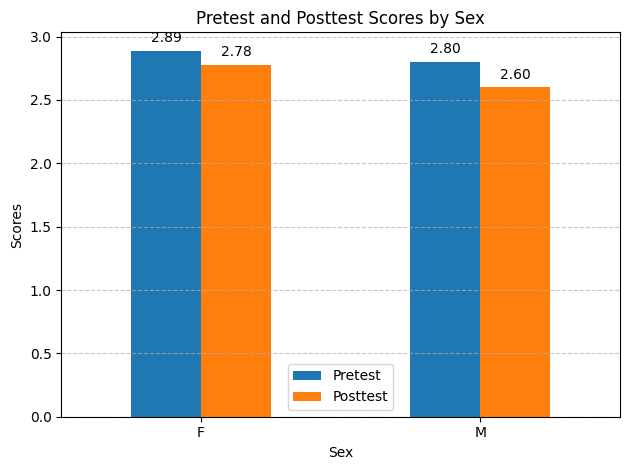

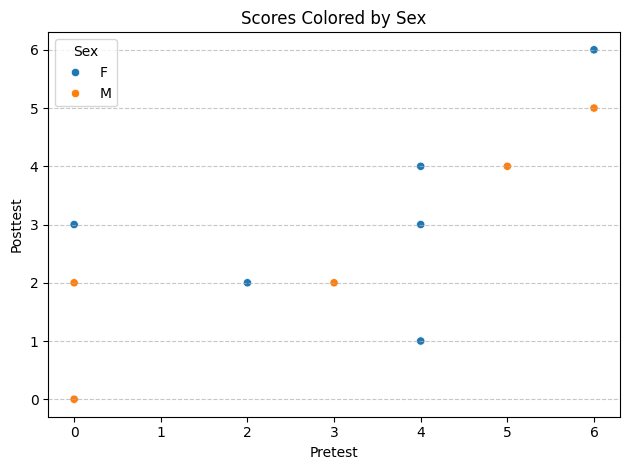

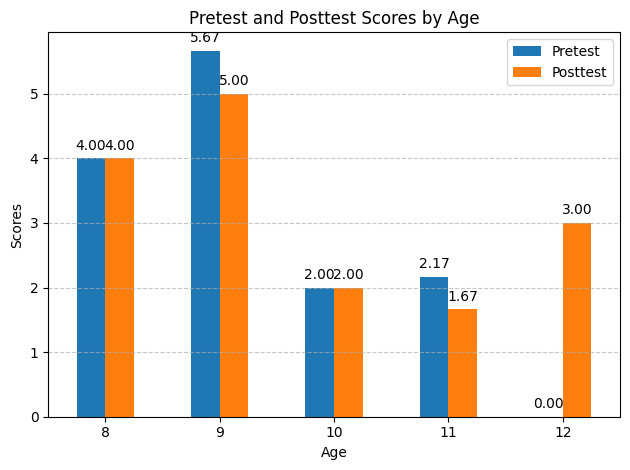

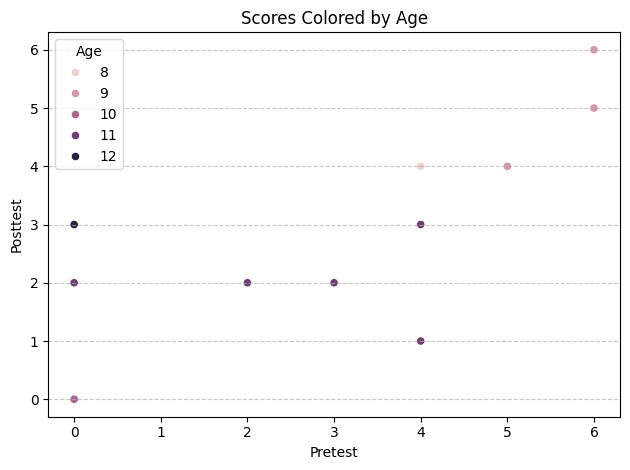

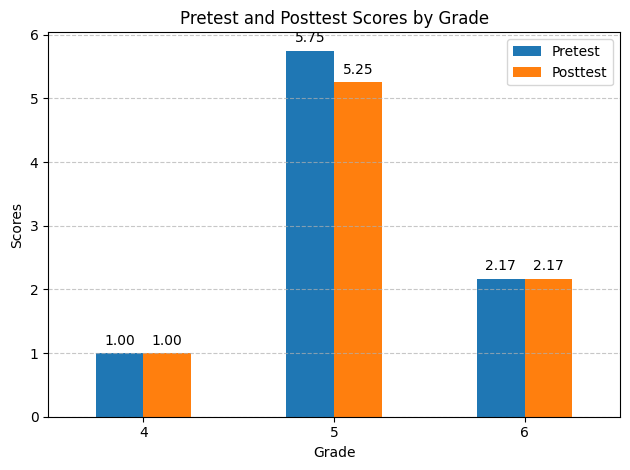

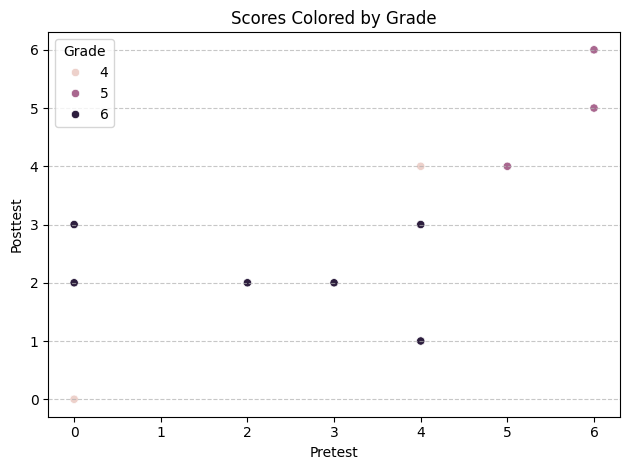

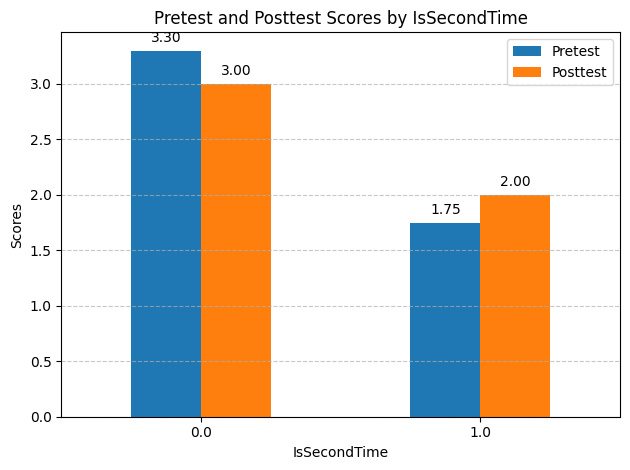

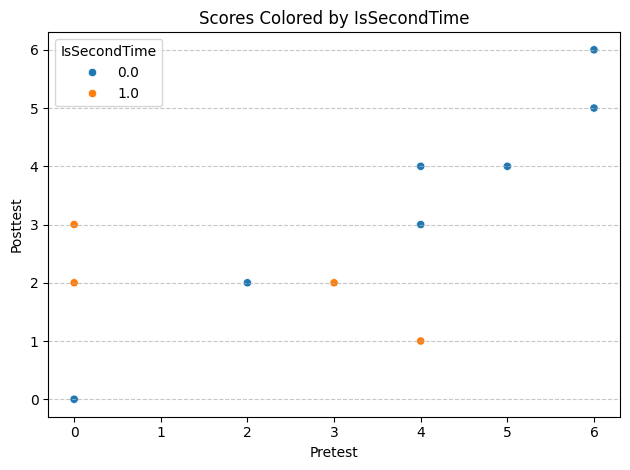

In [10]:
for col in ['Sex', 'Age', 'Grade', 'IsSecondTime']:
    DoPretestPosttestComparissonBar(df_Scores[[col, 'Pretest', 'Posttest']], col)
    DoScoresnPlot(df_Scores[[col, 'Pretest', 'Posttest']], col)

# EDA
I highly discourage testing subgroups considering the sample sizes are insanely inaccurate representations of population.

Use descriptive stats instead to see the difference between cases you discovered.

In [11]:
def DoBarComparisson(col : str):    
    df_Scores[[col, 'Pretest', 'Posttest']].groupby(col).mean().plot(kind='bar')
    
    plt.legend()
    plt.tight_layout()

    plt.title(f'Avg Scores by {col}')
    plt.show()


def DoPlotComparisson(col : str):    
    sns.scatterplot(df_Scores, x='Pretest', y='Posttest', hue=col)    
    plt.legend()
    plt.tight_layout()

    plt.title(f'Scores by {col}')
    plt.show()

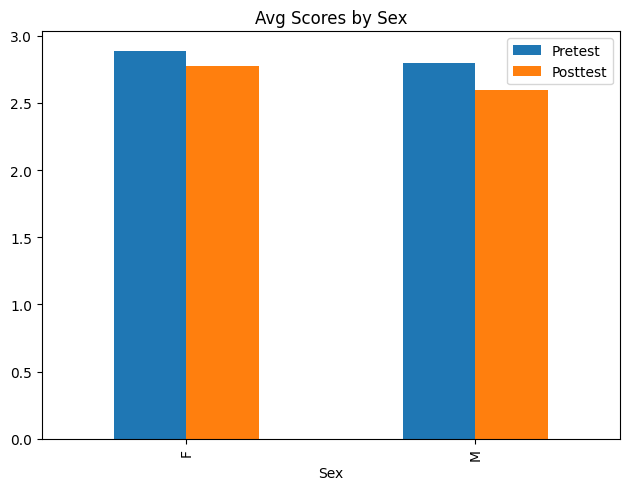

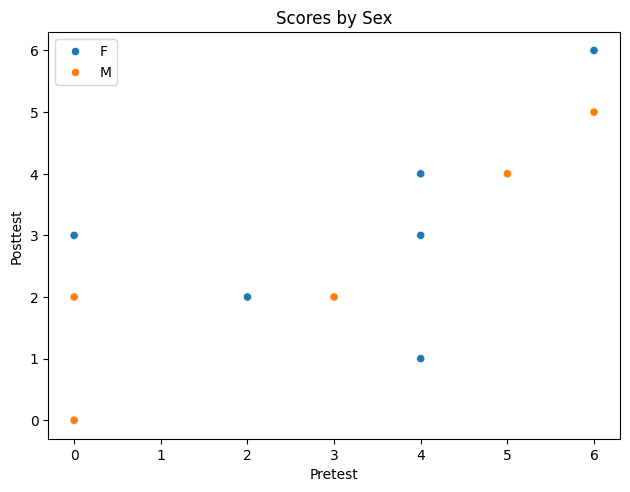

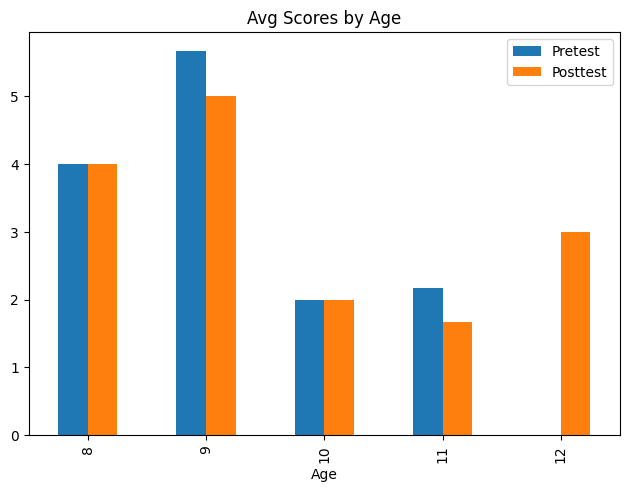

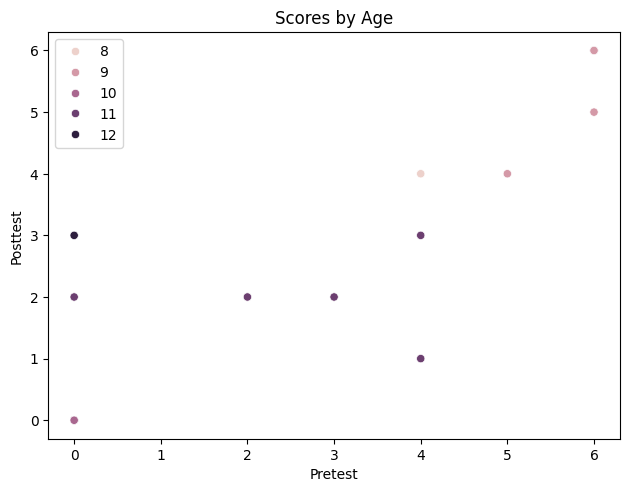

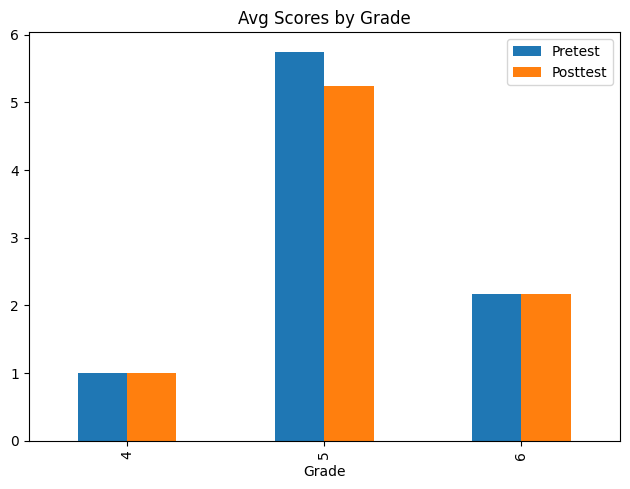

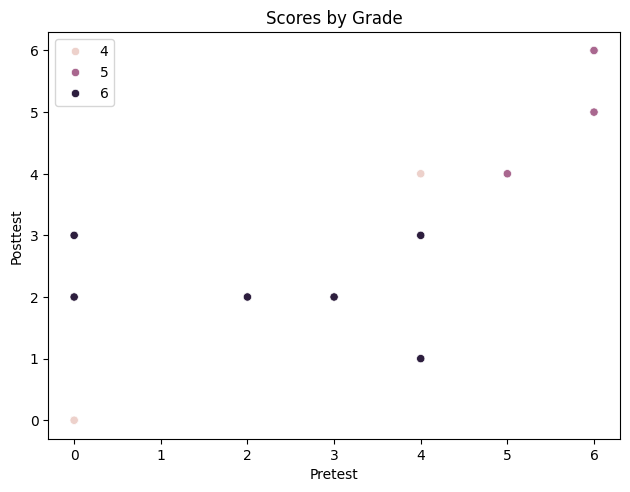

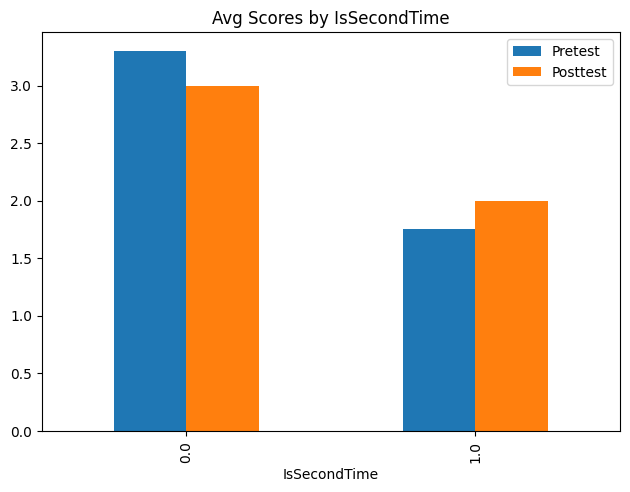

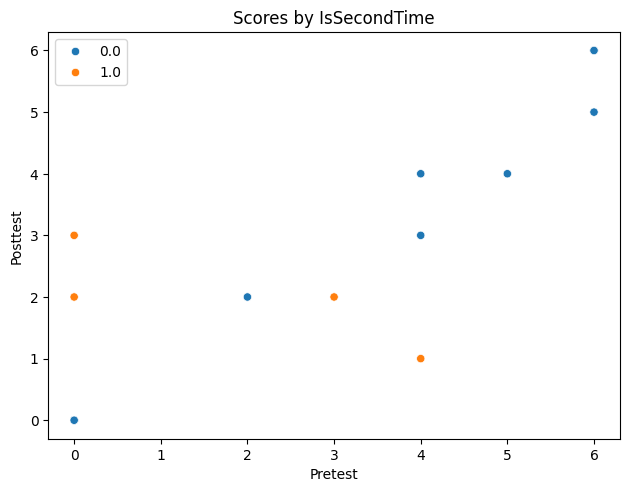

In [12]:
for col in ['Sex','Age', 'Grade', 'IsSecondTime']:
    DoBarComparisson(col)
    DoPlotComparisson(col)